In [1]:
import pandas as pd
import numpy as np
import netCDF4 as nc
import scipy as sc
from matplotlib import path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
#import windrose as wr
#import statsmodels.api as sm
#import plotly as pltl
import cartopy.crs as ccrs
#from mpl_toolkits.basemap import Basemap
#import xarray as xr
from datetime import datetime, timedelta
#import shapely.geometry as shg

## Информация по набору данных

In [2]:
file=r'C:\Users\user\Desktop\IO\AMK_87\era5_wind_Bransfield_daily.nc'
data = nc.Dataset(file,'r')

In [3]:
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2021-11-28 00:25:16 GMT by grib_to_netcdf-2.23.0: /opt/ecmwf/mars-client/bin/grib_to_netcdf -S param -o /cache/data9/adaptor.mars.internal-1638058938.1266234-28715-11-bca0bec0-19d0-408b-85a8-a6148a228bc9.nc /cache/tmp/bca0bec0-19d0-408b-85a8-a6148a228bc9-adaptor.mars.internal-1638057315.8719783-28715-22-tmp.grib
    dimensions(sizes): longitude(61), latitude(21), expver(2), time(15668)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 expver(expver), int32 time(time), int16 u10(time, expver, latitude, longitude), int16 v10(time, expver, latitude, longitude)
    groups: 

In [8]:
print(data['time'])
print(pd.to_datetime(data['time'][15667], unit='h', origin='1900-01-01 00:00:00.0'))

<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (15668,)
filling on, default _FillValue of -2147483647 used
2021-11-23 12:00:00


In [7]:
print(data['expver'])
print(data['expver'][:])

<class 'netCDF4._netCDF4.Variable'>
int32 expver(expver)
    long_name: expver
unlimited dimensions: 
current shape = (2,)
filling on, default _FillValue of -2147483647 used
[1 5]


In [8]:
print(data['longitude'])
print(data['longitude'][9:42])

<class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (61,)
filling on, default _FillValue of 9.969209968386869e+36 used
[-62.75 -62.5  -62.25 -62.   -61.75 -61.5  -61.25 -61.   -60.75 -60.5
 -60.25 -60.   -59.75 -59.5  -59.25 -59.   -58.75 -58.5  -58.25 -58.
 -57.75 -57.5  -57.25 -57.   -56.75 -56.5  -56.25 -56.   -55.75 -55.5
 -55.25 -55.   -54.75]


In [9]:
print(data['latitude'])
print(data['latitude'][5:-1])

<class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (21,)
filling on, default _FillValue of 9.969209968386869e+36 used
[-61.25 -61.5  -61.75 -62.   -62.25 -62.5  -62.75 -63.   -63.25 -63.5
 -63.75 -64.   -64.25 -64.5  -64.75]


In [13]:
data['v10']

<class 'netCDF4._netCDF4.Variable'>
int16 v10(time, expver, latitude, longitude)
    scale_factor: 0.000738835255830078
    add_offset: 1.2070433020986475
    _FillValue: -32767
    missing_value: -32767
    units: m s**-1
    long_name: 10 metre V wind component
unlimited dimensions: 
current shape = (15668, 2, 21, 61)
filling on

In [10]:
20088/360

55.8

In [11]:
40008.55/360

111.13486111111112

## Входные параметры

In [9]:
dig = 30 #угол наклона прямоугольника
A = [-62,-63.1] #координаты нижнего левого угла прямоугольника 
par_len = 20088 #длина параллели на 60° ю.ш. в км
mer_len = 40008.55 #длина меридиана в км
a = 350 #длина прямоугольника в км
b = 115 #ширина прямоугольника в км

# dig = 45 #угол наклона прямоугольника
# A = [-58,-62.5] #координаты верхнего левого угла прямоугольника 
# a = 200 #длина прямоугольника в км
# b = 100 #ширина прямоугольника в км

file = r'C:\Users\user\Desktop\IO\AMK_87\era5_wind_Bransfield_daily.nc'
data = nc.Dataset(file,'r')
#индексы граничный значений по широте, долготе, времени
i_minlat = 5
i_maxlat = -1
i_minlon = 9
i_maxlon = 42
i_mint = 0
i_maxt = 15667

## Обработка данных

In [10]:
polygon, coord = poly(dig, a, b, A, mer_len, par_len)

lon = data['longitude'][i_minlon:i_maxlon] #долготы интересующего нас района
lat = data['latitude'][i_minlat:i_maxlat] #широты интересующего нас района

f = open(r'C:\Users\user\Desktop\IO\AMK_87\Bransfield_mean_wind_since_1979.txt', 'w')
print('date time u v u_rot v_rot', file=f)

for t in range(i_mint,i_maxt+1):
    u = data['u10'][t, 1, i_minlat:i_maxlat, i_minlon:i_maxlon]
    v = data['v10'][t, 1, i_minlat:i_maxlat, i_minlon:i_maxlon]
    if type(u[0,0]) is not np.float64:
        u = data['u10'][t, 0, i_minlat:i_maxlat, i_minlon:i_maxlon]
        v = data['v10'][t, 0, i_minlat:i_maxlat, i_minlon:i_maxlon]
    
    u_masked, v_masked = masked(lat, lon, u, v, polygon)
    
    u_masked_rot, v_masked_rot = rotated(dig, u_masked, v_masked)
    
    date = pd.to_datetime(data['time'][t], unit='h', origin='1900-01-01 00:00:00.0')
    print(date, np.mean(u_masked), np.mean(v_masked), np.mean(u_masked_rot), np.mean(v_masked_rot), file=f)
    
f.close()

##  Отрисовка

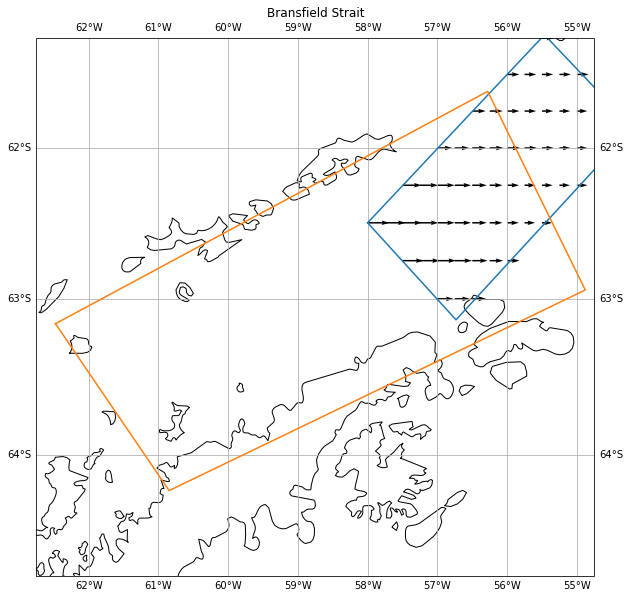

In [14]:
plt.figure(figsize=(10, 10))
#projection = ccrs.Orthographic(central_longitude=300.0, central_latitude=-62.0)
#projection = ccrs.Miller()
#projection = ccrs.PlateCarree()
projection = ccrs.Mercator()
#projection = ccrs.InterruptedGoodeHomolosine()

ax1 = plt.axes(projection=projection)
#ax1.stock_img()
ax1.coastlines('10m')
ax1.gridlines(draw_labels=True, ylocs=lat[3::4], xlocs=lon[3::4], x_inline=False, y_inline=False)
ax1.quiver(lon, lat, u_masked, np.zeros_like(v_masked), angles='xy', transform=ccrs.PlateCarree())
ax1.plot(coord[:, 0], coord[:, 1], transform=ccrs.PlateCarree())
ax1.plot([297.52456386, 303.72095293986, 305.12036215902, 299.15372683156, 297.52456386], [ -63.161412317632, -61.61579616485, -62.942101917575, -64.223153143305,  -63.161412317632], transform=ccrs.PlateCarree())
ax1.set_title('Bransfield Strait')
ax1.set_extent([lon[0], lon[-1], lat[0], lat[-1]])
#ax1.legend()

## Функции

In [2]:
def poly(dig, a, b, A, mer_len, par_len):
    rad = np.radians(dig) #угол наклона полигона относительно параллели в радианах
    x_rot=np.array([ np.cos(rad), np.sin(rad)]) #повернутый x-базис вектор
    y_rot=np.array([ np.cos(rad+np.pi/2), np.sin(rad+np.pi/2)]) #повернутый y-базис вектор

    B = 0*x_rot-b*y_rot
    C = a*x_rot-b*y_rot
    D = a*x_rot+0*y_rot
    
    B = [A[0]+B[0]*360/par_len, A[1]+B[1]*360/mer_len]
    C = [A[0]+C[0]*360/par_len, A[1]+C[1]*360/mer_len]
    D = [A[0]+D[0]*360/par_len, A[1]+D[1]*360/mer_len]
    
    polygon = path.Path([A, B, C, D]) #полигон интересующей нас области (Брансфилд)
    return polygon, np.array([A, B, C, D, A])

In [3]:
def masked(lat, lon, u, v, polygon):
    xx,yy = np.meshgrid(lon, lat) #получаем массивы широт и долгот каждого узла сетки
    coord = np.hstack((xx.flatten()[:,np.newaxis], yy.flatten()[:,np.newaxis])) #получаем массив координат всех узлов сетки
    mask = np.logical_not(polygon.contains_points(coord)) #маска входящих в полигон значений
    #mask = polygon.contains_points(list(zip(xx.flatten(), yy.flatten()))) #можно и так, выглядит понятнее, но работает медленнее
    u_masked = np.ma.masked_array(u, mask.reshape(len(lon),len(lat)))
    v_masked = np.ma.masked_array(v, mask.reshape(len(lon),len(lat)))
    return u_masked, v_masked


In [4]:
def rotated(dig, u, v):
    rad = np.radians(dig) #угол наклона полигона относительно параллели в радианах
    u_rot=u*np.cos(rad)+v*np.sin(rad)
    v_rot=u*np.cos(rad+np.pi/2)+v*np.sin(rad+np.pi/2)
    return u_rot, v_rot
    